In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
size = 400
L = 10.0
dt = 0.002
bigT = 40000

G = 1.1
a = 0.5

In [3]:
x = np.linspace(-L,L,size)
dx = x[1]-x[0]
T = np.zeros((size,size))
T2 = np.zeros((size,size))
V = np.zeros((size,size))
Q = np.zeros((size,size))
V2Grav = np.zeros((size,size))
I = np.identity(size)
I = I.astype(complex)
psi = np.zeros((size))

phi = -np.exp(-x*x/2.0)/100.0
phi[0] = 0.0
phi[size-1] = 0.0

In [4]:
def setupPsi():
    global psi
    psi = np.exp(-x*x/2.0)
    normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
    psi = psi/normalization

    for index, value in enumerate(psi):
        if(value<1e-10):
            psi[index] = 0
    psi = psi.astype(complex)

def setupT():
    global T, T2
    for i in range(size):
        T[i][i] = -2.0
        if(i!=size-1):
            T[i][i+1] = 1.0
            T2[i][i+1] = 1.0/2.0/x[i]
        if(i!=0):
            T[i][i-1] = 1.0
            T2[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    T2 = -1.0/dx*T2
    T = T.astype(complex)
    T2 = T2.astype(complex)
        

def setupV():
    global V
    for i in range(size):
        V[i][i] = 1.0/2.0*x[i]*x[i]
    V = V.astype(complex)

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = 4.0*np.pi*a*np.absolute(psi[i])*np.absolute(psi[i])

    Q = Q.astype(complex)

def setupV2Grav():
    global V2Grav, phi
    VGrav = np.zeros((size,size))
    VGrav2 = np.zeros((size))
    for i in range(size):
        if(i!=size-1 and i!=0):
            VGrav2[i] = 2.0*np.pi*dx*dx*np.absolute(psi[i])*np.absolute(psi[i])*G
            VGrav[i][i+1] = 1.0/2.0 + 1.0/2.0*dx/x[i]
            VGrav[i][i-1] = 1.0/2.0 - 1.0/2.0*dx/x[i]

    toler = 3e-8

    while(True):
        phiNew = np.dot(VGrav, phi) - VGrav2
        error = np.abs((phiNew-phi)/phi)
        phi = phiNew
        if(np.nanmax(error[error!=np.inf])<toler):
            break
        
    for i in range(size//2):
        V2Grav[i][i] = phi[size-i-1]
        V2Grav[size-i-1][size-i-1] = phi[size-i-1]

    V2Grav.astype(complex)

In [5]:
setupPsi()
setupT()
setupV()
setupQ()
setupV2Grav()

/tmp/ipykernel_5005/1052070655.py:56: RuntimeWarning: invalid value encountered in divide
  error = np.abs((phiNew-phi)/phi)


In [6]:
def setupU1U2():
    global U1
    global U2
    U1 = I + 1.0j*dt/2.0*(T+T2+V+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+T2+V+Q+V2Grav)

0.0 0.17953072834505243
0.002 0.17953059221737824
0.004 0.17953018388359682
0.006 0.17952950349260094
0.008 0.17952855129387107
0.01 0.17952732763658555
0.012 0.17952583296918698
0.014 0.17952406783937802
0.016 0.17952203289360358
0.018000000000000002 0.17951972887646142
0.02 0.1795171566300135
0.022 0.17951431709298712
0.024 0.17951121129989717
0.026000000000000002 0.1795078403800703
0.028 0.1795042055565955
0.03 0.17950030814520532
0.032 0.17949614955306764
0.034 0.17949173127748558
0.036000000000000004 0.17948705490453018
0.038 0.17948212210760273
0.04 0.17947693464593695
0.042 0.1794714943630155
0.044 0.17946580318492722
0.046 0.17945986311867418
0.048 0.17945367625040265
0.05 0.17944724474358528
0.052000000000000005 0.17944057083715184
0.054 0.1794336568435707
0.056 0.17942650514688374
0.058 0.1794191182006982
0.06 0.17941149852614033


/tmp/ipykernel_5005/1052070655.py:56: RuntimeWarning: invalid value encountered in divide
  error = np.abs((phiNew-phi)/phi)


0.062 0.17940364870978212
0.064 0.1793955714015179
0.066 0.1793872693124163
0.068 0.1793787452125453
0.07 0.17937000192877697
0.07200000000000001 0.17936104234257355
0.074 0.17935186938775496
0.076 0.17934248604825936
0.078 0.1793328953558683
0.08 0.1793231003879472
0.082 0.1793131042651848
0.084 0.17930291014931535
0.08600000000000001 0.17929252124084574
0.088 0.1792819407767854
0.09 0.1792711720283857
0.092 0.17926021829888822
0.094 0.17924908292128364
0.096 0.17923776925608165
0.098 0.1792262806890975
0.1 0.17921462062925922
0.10200000000000001 0.17920279250643728
0.10400000000000001 0.1791907997692944
0.106 0.17917864588315685
0.108 0.17916633432791845
0.11 0.1791538685959618
0.112 0.17914125219011154
0.114 0.17912848862163086
0.116 0.17911558140824943
0.11800000000000001 0.17910253407221075
0.12 0.17908935013835423
0.122 0.17907603313225667
0.124 0.1790625865783956
0.126 0.1790490139983517
0.128 0.17903531890905086
0.13 0.17902150482104007
0.132 0.17900757523682725
0.134 0.1789935

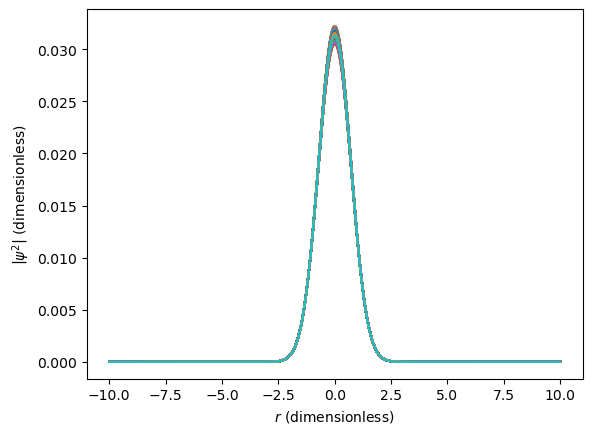

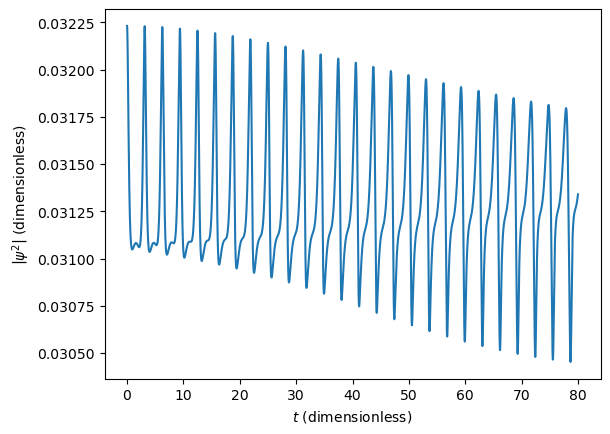

In [7]:
setupU1U2()
hello = []
ts = []
for t in range(bigT):
    print(t*dt, np.absolute(psi[size//2]))
    hello.append(np.absolute(psi[size//2])*np.absolute(psi[size//2]))
    ts.append(t*dt)
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    setupQ()
    setupV2Grav()
    setupU1U2()

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

0.0125
0.325 7.487385888110386
0.6375000000000001 4.422399813297743
0.9625 2.6856678131023983


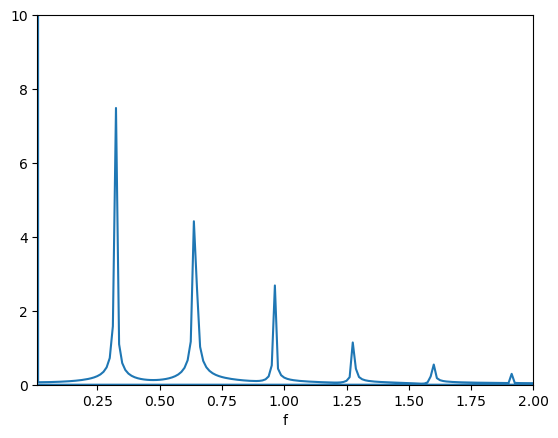

In [10]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,2.0)
plt.ylim(0.0,10.0)
plt.xlabel("f")

print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 2 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))